## Linear Regression: Rolling and Recursive

**Functions**

`sm.OLS`, `plt.title`, `plt.legend`, `plt.subplots`, `plt.plot`

### Exercise 35
For the same portfolios in the previous exercise, compute rolling $\beta$s
using 60 consecutive observations.

In [71]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from tqdm import tqdm

ff = pd.read_hdf("data/ff.h5","ff")
ff.head()

factors = sm.add_constant(ff.iloc[:,:3])
portfolios = ff.iloc[:,4:]
portfolios = portfolios[["SMALL LoBM", "SMALL HiBM", "BIG LoBM","BIG HiBM"]]
factors.head()

,const,Mkt-RF,SMB,HML
1926-07-31,1.0,2.96,-2.30,-2.87
1926-08-31,1.0,2.64,-1.40,4.19
1926-09-30,1.0,0.36,-1.32,0.01
1926-10-31,1.0,-3.24,0.04,0.51
1926-11-30,1.0,2.53,-0.20,-0.35


In [72]:
rolling_betas = {}
rolling_se = {}
nobs = portfolios.shape[0]

for column in portfolios:
    # create a placeholder for beta estimates and the se estimates (rolling ones are dictionaries so we will not use now)
    betas = factors.copy()
    betas.loc[:,:] = np.nan # Nan values - but crucially in the same dimension as the factors matrix!
    se = betas.copy()

    portfolio = portfolios[column] # easier than selecting each portfolio every single time in the interior for loop

    for i in range(60,nobs):
        y = portfolio.iloc[i-60:i]
        x = factors.iloc[i-60:i]
        res = sm.OLS(y,x).fit(cov_type="HC0")
        betas.iloc[i] = res.params
        se.iloc[i] = res.bse
    rolling_betas[column] = betas
    rolling_se[column] = se

print("HELLO")

HELLO


### Exercise 36

For each of the four $\beta$s, produce a plot containing four series: 

* A line corresponding to the constant $\beta$ (full sample) 
* The $\beta$ estimated on the rolling sample 
* The constant $\beta$ plus $1.96 \times$ the variance of a 60-observation estimate of $\beta$. 
  The 60-month covariance can be estimated using a full sample VCV and rescaling it by T/60 
  where T is the length of the full sample used to estimate the VCV. Alternatively, the VCV
  could be estimated by first estimating the 60-month VCV for each sub-sample and then averaging
  these.
* The constant $\beta$ minus $1.96 \times$ the variance of a 60-observation estimate of $\beta$. 

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rc("figure",figsize=(16,6))
sns.set_style("darkgrid")
colors = sns.color_palette()

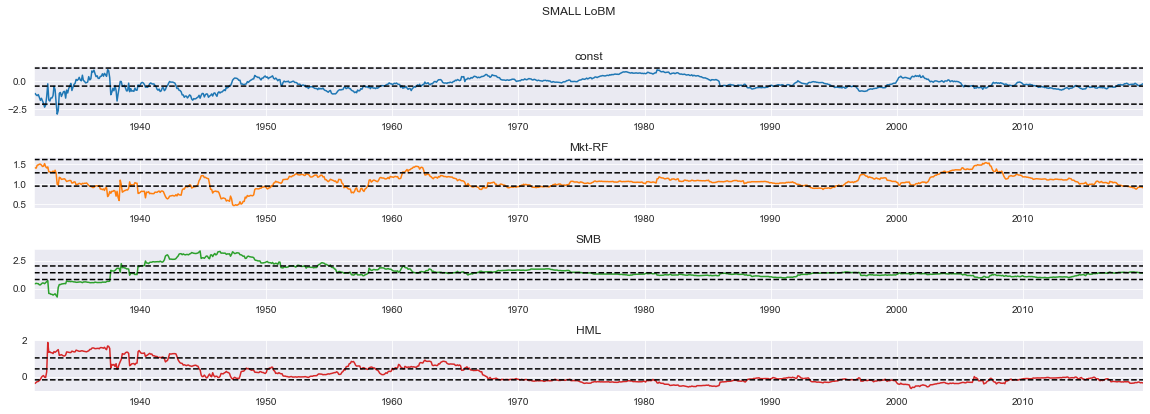

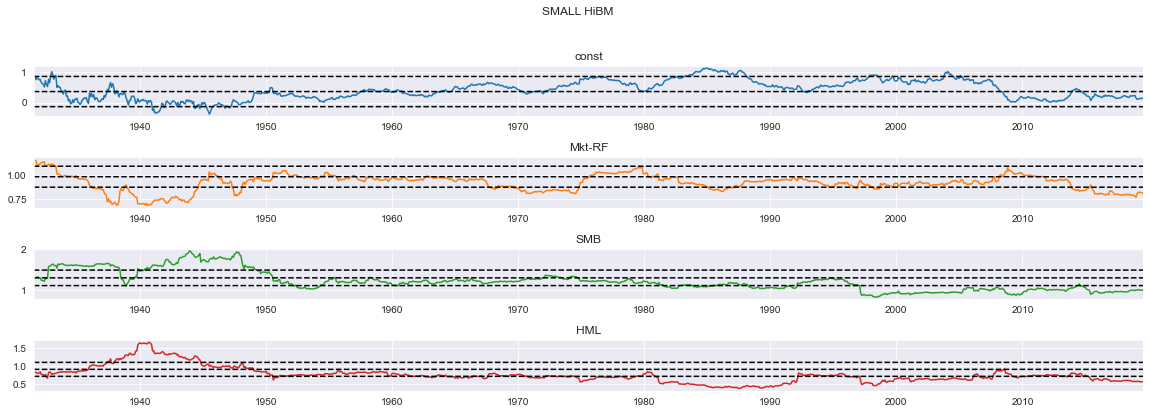

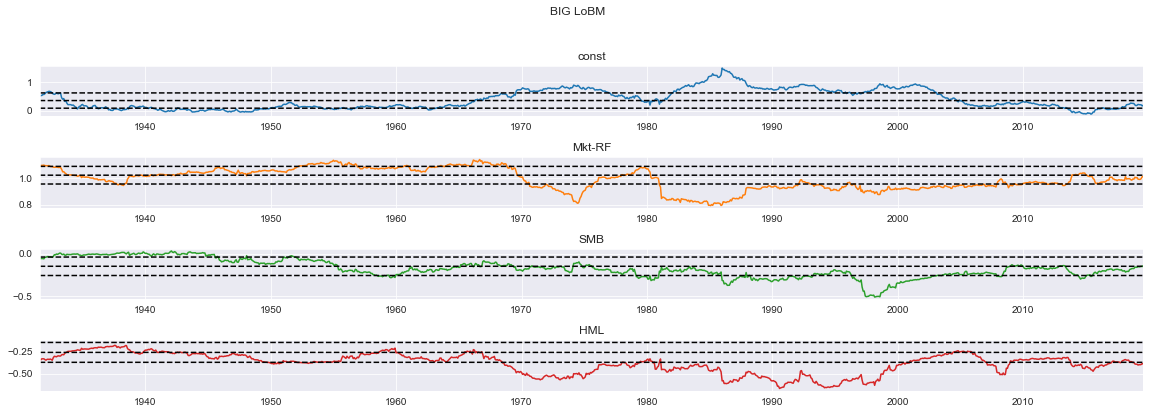

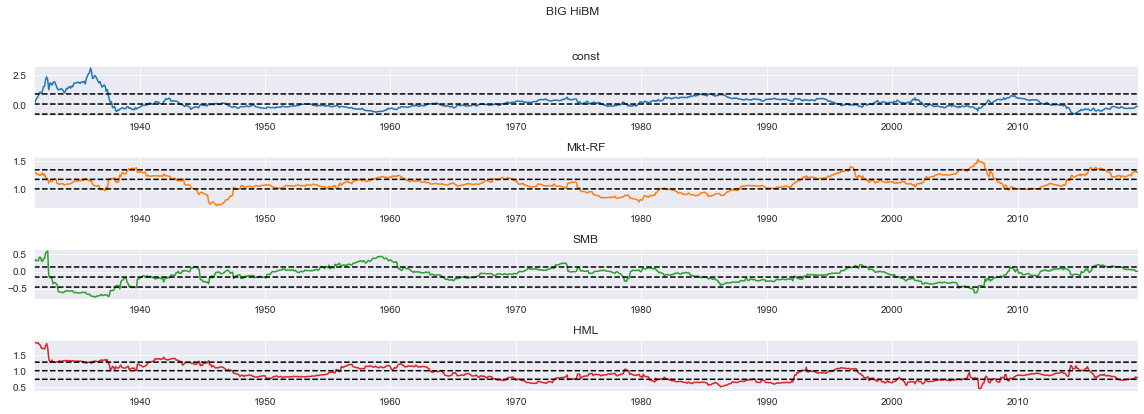

In [75]:
for column in portfolios:
    betas = rolling_betas[column]
    ses = rolling_se[column]
    variances = ses ** 2
    const_std_errs = np.sqrt(variances.mean(axis=0))
    full_sample = sm.OLS(portfolios[column], factors).fit(cov_type="HC0")
    fig, axes = plt.subplots(4,1)
    plt.suptitle(column)

    for i in range(4):
        factor_name = factors.columns[i]
        const_se = const_std_errs.iloc[i]
        const_beta = full_sample.params.iloc[i]
        data = pd.DataFrame({"B": betas.iloc[:,i]})
        data["Constant B"] = full_sample.params.iloc[i]
        data["Upper CI"] = const_beta + 1.96 * const_se
        data["Lower CI"] = const_beta - 1.96 * const_se
        data = data.dropna()

        ax = axes[i]
        ax.plot(data.index, data["B"],color = colors[i])
        ax.plot(data.index, data["Constant B"], linestyle="--", color="black")
        ax.plot(data.index, data["Upper CI"], linestyle="--", color="black")
        ax.plot(data.index, data["Lower CI"], linestyle="--", color="black")
        ax.set_title(factor_name)
        ax.set_xlim(data.index[0], data.index[-1])
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])


### Exercise 37

Do the factor exposures appear constant?

In [ ]:
# no, they do not appear to be constant over time

### Exercise 38

What happens if only the market is used as a factor (repeat the exercise excluding SMB and HML).

 As seen below, the market factor is estimated to have a much larger effect when it is the sole regressor - this is an example of ommited variable bias - variation in the dependent variable that is better explaied by other factors is being soaked up into the market factor

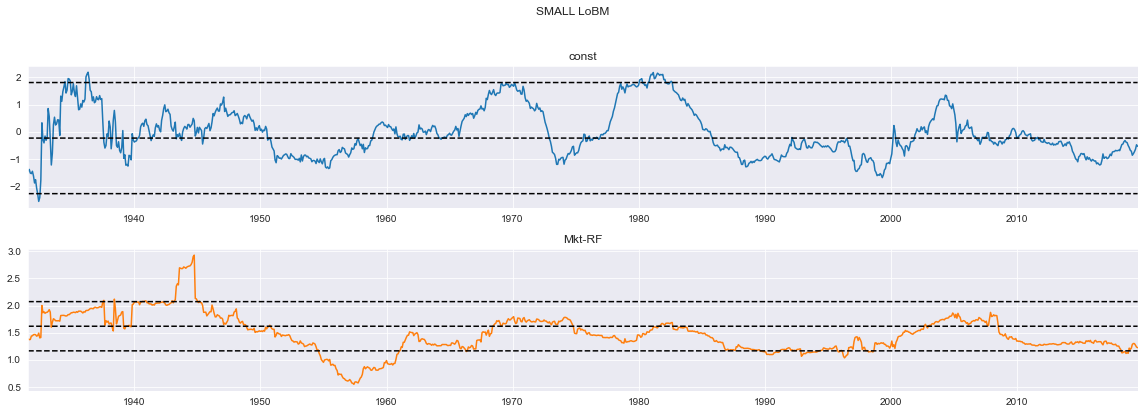

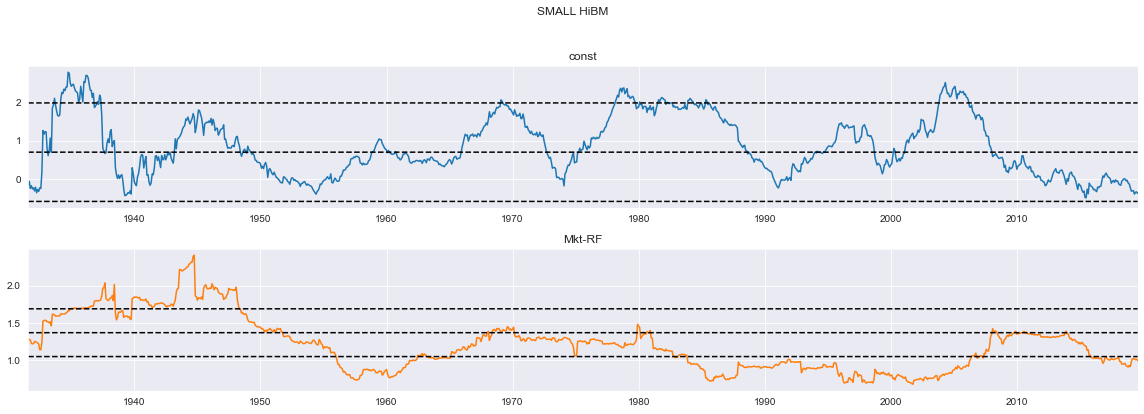

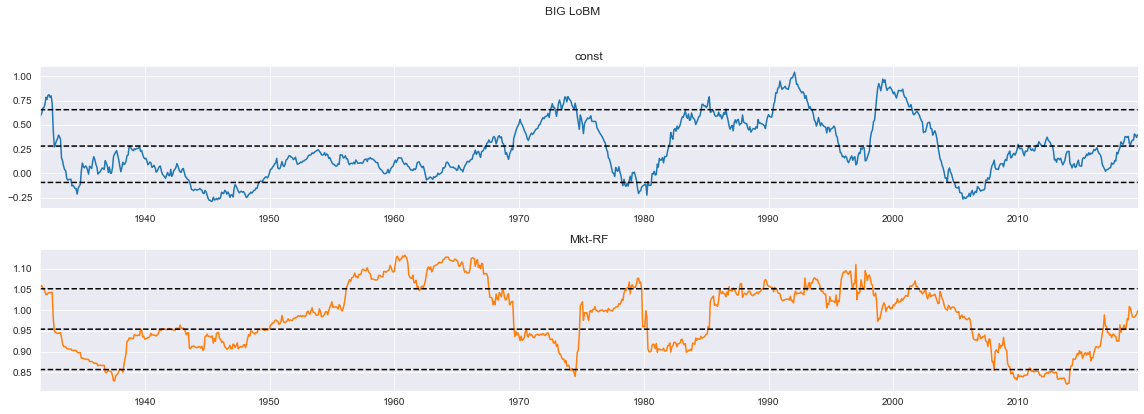

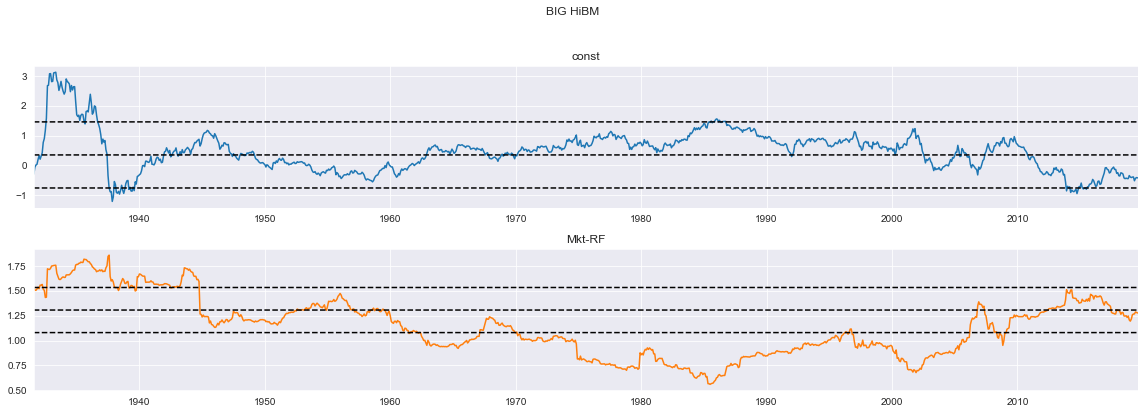

In [80]:
market = sm.add_constant(ff.iloc[:,0])
portfolios = ff.iloc[:,4:]
portfolios = portfolios[["SMALL LoBM", "SMALL HiBM", "BIG LoBM","BIG HiBM"]]

rolling_betas = {}
rolling_se = {}
nobs = portfolios.shape[0]

for column in portfolios:
    # create a placeholder for beta estimates and the se estimates (rolling ones are dictionaries so we will not use now)
    betas = market.copy()
    betas.loc[:,:] = np.nan # Nan values - but crucially in the same dimension as the factors matrix!
    se = betas.copy()

    portfolio = portfolios[column] # easier than selecting each portfolio every single time in the interior for loop

    for i in range(60,nobs):
        y = portfolio.iloc[i-60:i]
        x = market.iloc[i-60:i]
        res = sm.OLS(y,x).fit(cov_type="HC0")
        betas.iloc[i] = res.params
        se.iloc[i] = res.bse
    rolling_betas[column] = betas
    rolling_se[column] = se


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rc("figure",figsize=(16,6))
sns.set_style("darkgrid")
colors = sns.color_palette()

for column in portfolios:
    betas = rolling_betas[column]
    ses = rolling_se[column]
    variances = ses ** 2
    const_std_errs = np.sqrt(variances.mean(axis=0))
    full_sample = sm.OLS(portfolios[column], market).fit(cov_type="HC0")
    fig, axes = plt.subplots(2,1)
    plt.suptitle(column)

    for i in range(2):
        market_name = market.columns[i]
        const_se = const_std_errs.iloc[i]
        const_beta = full_sample.params.iloc[i]
        data = pd.DataFrame({"B": betas.iloc[:,i]})
        data["Constant B"] = full_sample.params.iloc[i]
        data["Upper CI"] = const_beta + 1.96 * const_se
        data["Lower CI"] = const_beta - 1.96 * const_se
        data = data.dropna()

        ax = axes[i]
        ax.plot(data.index, data["B"],color = colors[i])
        ax.plot(data.index, data["Constant B"], linestyle="--", color="black")
        ax.plot(data.index, data["Upper CI"], linestyle="--", color="black")
        ax.plot(data.index, data["Lower CI"], linestyle="--", color="black")
        ax.set_title(market_name)
        ax.set_xlim(data.index[0], data.index[-1])
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])